# Inference Pipeline with Scikit-learn and Linear Learner

1. fit/train a sklearn pre-processor
   
   it will perform preprocessing of numeric cat cols
   
** numeric : imputation, scaling

** categoric : imputation, one-hot-encoding
   
** also perform batch transformation of train/test data to be used for ml_model training
   
   
2. train sklearn ml model (RF regressor)

3. build up inference-ml-pipeline
    raw_data --> [preprocessing ==> ml_model] --> prediction
    
4. deploy inference-ml-pipeline as an endpoint

5. prediction using the endpoint

In [1]:
# 1. SHAP
# 2. store artifacts of sm train job

# Utils

In [24]:
%load_ext autoreload
%autoreload 2

import json
import io
from urllib.parse import urlparse
import boto3


def get_s3uri_df_data(s3uri=None, return_df=False, header=None):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    print(bucket_name)
    print(prefix)
    obj = s3.Object(bucket_name, prefix)
    data_stream = obj.get()["Body"].read().decode('utf-8')   
    
    if return_df:
        df = pd.read_csv(StringIO(input_data), header=header)
        return df
    
    return data_stream


def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    print(bucket_name)
    print(prefix)
    print(file_name)
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!pwd

/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic


In [4]:
import sagemaker
from sagemaker import get_execution_role

import os
import numpy as np
import pandas as pd

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

# S3 prefix
S3_BUCKET = "sklearn-pipeline"
S3_PREFIX = 'sklearn-pipeline-titanic'

S3_BUCKET, S3_PREFIX

('sklearn-pipeline', 'sklearn-pipeline-titanic')

In [5]:
col_to_predict = "survived"

# 1. Get raw data

In [6]:
SEED = 100

RAW_FILE       = 'titanic_dataset.csv'
WORK_DIRECTORY = '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir'

RAW_FILE_PATH  = "{}/raw_data/{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_TRAIN_PATH = "{}/train/train_{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_TEST_PATH  = "{}/test/test_{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_VAL_PATH   = "{}/val/val_{}".format(WORK_DIRECTORY, RAW_FILE)

PP_TRAIN_PATH = "{}/pp_train/train_{}".format(WORK_DIRECTORY, RAW_FILE)
PP_TEST_PATH  = "{}/pp_test/test_{}".format(WORK_DIRECTORY, RAW_FILE)
PP_VAL_PATH   = "{}/pp_val/val_{}".format(WORK_DIRECTORY, RAW_FILE)

ARTIFACTS_PATH = "{}/artifacts".format(WORK_DIRECTORY)

In [7]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X[col_to_predict] = y
X["user_id"] = ["user_"+str(i) for i in range(len(X))]

from pre_processing_script import COLLIST_ALL, COLLIST_FEATURE
X = X[COLLIST_ALL]

# train, test, val : 65%, 25%, 10%
train_data, test_data, val_data = np.split(X.sample(frac=1, random_state=SEED), [int(.65*len(X)), int(.9*len(X))])
val_data = val_data[COLLIST_FEATURE]

# save the data
train_data.to_csv(path_or_buf=RAW_TRAIN_PATH, index=False, header=None)
test_data.to_csv(path_or_buf=RAW_TEST_PATH, index=False, header=None)
val_data.to_csv(path_or_buf=RAW_VAL_PATH, index=False, header=None)

print("raw_data: {}, train: {}, test: {}, val: {}".format(X.shape, train_data.shape, test_data.shape, val_data.shape))
X.head(2)

raw_data: (1309, 7), train: (850, 7), test: (328, 7), val: (131, 5)


survived user_id      age      fare embarked     sex  pclass
0        1  user_0  29.0000  211.3375        S  female     1.0
1        1  user_1   0.9167  151.5500        S    male     1.0

In [8]:
train_data[col_to_predict].value_counts(), test_data[col_to_predict].value_counts()

(0    526
 1    324
 Name: survived, dtype: int64,
 0    202
 1    126
 Name: survived, dtype: int64)

In [9]:
# reverify that the train/test/data are successfully created and saved
train_data.head(1)

survived   user_id   age   fare embarked   sex  pclass
173        0  user_173  32.5  211.5        C  male     1.0

In [10]:
# reverify that the train/test/data are successfully created and saved
temp_train_data = pd.read_csv(filepath_or_buffer=RAW_TRAIN_PATH, header=None)
temp_train_data.head(1)

0         1     2      3  4     5    6
0  0  user_173  32.5  211.5  C  male  1.0

## Upload the data for training

In [11]:
s3_input_raw_train = sagemaker_session.upload_data(
    path=RAW_TRAIN_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_train'))

s3_input_raw_test = sagemaker_session.upload_data(
    path=RAW_TEST_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_test'))

s3_input_raw_val = sagemaker_session.upload_data(
    path=RAW_VAL_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_val'))

s3_input_raw_train, s3_input_raw_test, s3_input_raw_val

('s3://sklearn-pipeline/sklearn-pipeline-titanic/data_train/train_titanic_dataset.csv',
 's3://sklearn-pipeline/sklearn-pipeline-titanic/data_test/test_titanic_dataset.csv',
 's3://sklearn-pipeline/sklearn-pipeline-titanic/data_val/val_titanic_dataset.csv')

# Data pre-processing

## local pp

In [12]:
#from sklearn import set_config
#set_config(display='diagram')
#preprocessor

In [13]:
train_data_local_dir = "/".join(RAW_TRAIN_PATH.split("/")[:-1])
artifacts_local_dir  = ARTIFACTS_PATH
artifacts_local_dir, train_data_local_dir

! python pre_processing_script.py --output-data-dir /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/artifacts/ \
                                  --model-dir /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/artifacts/ \
                                  --train /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/train/

========================================_sklearn-pre-processor_========================================
extracting arguments
data loading completed:
data shape :  (850, 7)
columns : ['survived', 'user_id', 'age', 'fare', 'embarked', 'sex', 'pclass']
loaded RAW data : 
 [[0 'user_173' 32.5 211.5 'C' 'male' 1]] 

to_predict_col : [0 1] : [526 324]

before pp : FEATURE data shape :  (850, 5)
columns (5 columns): ['age', 'fare', 'embarked', 'sex', 'pclass']
sample data : 
 [[32.5 211.5 'C' 'male' 1]] 

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s

after pp : FEATURE data shape :  (850, 10)
(IMP) column (10 columns): ['age' 'fare' 'x0_C' 'x0_Q' 'x0_S' 'x1_female' 'x1_male' 'x2_1' 'x2_2'
 'x2_3']
sample data : 
 [0.23750065 3.71563628 1.         0.         0.         0.
 1.         1.         0.         0.        ]

saved model at :  /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-class

In [16]:
%reload_ext autoreload
from pre_processing_script import model_fn as pp_model_fn
from pre_processing_script import predict_fn as pp_predict_fn
from pre_processing_script import input_fn as pp_input_fn

In [17]:
#s3_data_path = s3_input_raw_train
s3_data_path = s3_input_raw_val
model_dir = artifacts_local_dir

# verify model_fn
model     = pp_model_fn(model_dir)
print(type(model))

# verify input_fn
input_data = get_s3uri_df_data(s3uri=s3_data_path, return_df=False, header=None)
df = pp_input_fn(input_data, content_type="text/csv")
print(df.shape)

<class 'sklearn.compose._column_transformer.ColumnTransformer'>
sklearn-pipeline
sklearn-pipeline-titanic/data_val/val_titanic_dataset.csv
======================================== input_fn ========================================
This pred/val data i.e unlabelled, not include col_to_predict
df.shape :  (131, 5)
(131, 5)


In [21]:
# verify predict_fn
pp_data = pp_predict_fn(input_data=df, model=model)

print(pp_data.shape)
print(type(pp_data))

======================================== predict_fn ========================================
before pp :  data shape : (131, 5)
input data type : <class 'pandas.core.frame.DataFrame'>
test/pred job
only contain the feature data
after pp : data shape : (131, 10)
sample data : 
 [-1.69835544  0.08898475  0.          0.          1.          0.
  1.          0.          1.          0.        ]
(131, 10)
<class 'numpy.ndarray'>


In [22]:
import matplotlib.pyplot as plt
from sklearn import set_config

In [23]:
#model
f = plt.figure()
set_config(display='diagram')
model

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['embarked', 'sex', 'pclass'])],
                  verbose=True)

<Figure size 432x288 with 0 Axes>

In [25]:
# once local run is succesfull, train the container based model

## setup

In [148]:
PP_SCRIPT_NAME = 'pre_processing_script.py'

# preprocessor setup
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
sklearn_preprocessor = SKLearn(
                            entry_point=PP_SCRIPT_NAME,
                            role=role,
                            framework_version=FRAMEWORK_VERSION,
                            train_instance_type="ml.c4.xlarge",
                            sagemaker_session=sagemaker_session
                            )

## train

In [149]:
sklearn_preprocessor.fit({'train': s3_input_raw_train})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-19 17:13:26 Starting - Starting the training job...
2020-09-19 17:13:31 Starting - Launching requested ML instances......
2020-09-19 17:14:45 Starting - Preparing the instances for training.........
2020-09-19 17:16:00 Downloading - Downloading input data...
2020-09-19 17:16:54 Training - Downloading the training image...
2020-09-19 17:17:14 Training - Training image download completed. Training in progress.2020-09-19 17:17:14,895 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-09-19 17:17:14,897 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-19 17:17:14,907 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-19 17:17:30,712 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-19 17:17:30,724 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-19 17:17:30,735 sagemaker-training-

### batch transform the raw data to train/test data
required for training the ML model

In [29]:
"""
raw data + label : 9
features + label : 12

raw data : 8
features : 11 (this is pred model required data)

"""
print()

In [151]:
# Define a SKLearn Transformer from the trained SKLearn Estimator
pp_transformer = sklearn_preprocessor.transformer(
                                                    instance_count=1, 
                                                    instance_type='ml.m5.xlarge',
                                                    assemble_with = 'Line',
                                                    accept = 'text/csv'
                                                 )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [31]:
# Preprocess training data : s3_input_raw_train
pp_transformer.transform(s3_input_raw_train, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_train = pp_transformer.output_path

Waiting for transform job: sagemaker-scikit-learn-2020-09-19-12-50-09-236
............................2020-09-19 12:54:41,499 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-19 12:54:41,502 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-19 12:54:41,503 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

2020-09-19 12:54:41,499 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-19 12:54:41,502 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-19 12:54:41,503 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type applica

In [32]:

# batch preprocess test data : s3_input_raw_test
pp_transformer.transform(s3_input_raw_test, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_test = pp_transformer.output_path
"""
s3_pp_test = s3_pp_train
"""

Waiting for transform job: sagemaker-scikit-learn-2020-09-19-12-55-26-202
............................2020-09-19 12:59:56,614 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-19 12:59:56,617 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-19 12:59:56,618 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read

2020-09-19T12:59:59.977:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD



'\ns3_pp_test = s3_pp_train\n'

In [33]:
# only useful for assessing the ml_model only endpoint
"""
# batch preprocess val data : s3_input_raw_val
pp_transformer.transform(s3_input_raw_val, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_val = pp_transformer.output_path
"""
s3_pp_val = None


In [34]:
s3_input_raw_train

's3://sklearn-pipeline/sklearn-pipeline-titanic/data_train/train_titanic_dataset.csv'

In [35]:
s3_pp_train, s3_pp_test, s3_pp_val

('s3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-19-12-50-09-236',
 's3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-19-12-55-26-202',
 None)

# ML model (sklearn)

## local train

In [36]:
# fetch data
s3uri     = s3_pp_train
file_name = '{}.out'.format(RAW_TRAIN_PATH.split("/")[-1])
s3_obj = get_csv_output_from_s3(s3uri, file_name)
train_df_pp  = pd.read_csv(io.StringIO(s3_obj), sep=",", header=None)

"""
s3uri     = s3_pp_test
file_name = '{}.out'.format(RAW_TEST_PATH.split("/")[-1])
s3_obj = get_csv_output_from_s3(s3uri, file_name)
test_df_pp  = pd.read_csv(io.StringIO(s3_obj), sep=",", header=None)
"""
test_df_pp = train_df_pp.copy()


train_df_pp.to_csv(path_or_buf=PP_TRAIN_PATH, index=False, header=None)
test_df_pp.to_csv(path_or_buf=PP_TEST_PATH, index=False, header=None)
#val_df_pp.to_csv(path_or_buf=PP_VAL_PATH, index=False, header=None)

print(train_df_pp.shape, test_df_pp.shape)
train_df_pp.sample(2)

sagemaker-us-east-1-120286446822
sagemaker-scikit-learn-2020-09-19-12-50-09-236
train_titanic_dataset.csv.out
(850, 12) (850, 12)


0         1         2         3    4    5    6    7    8    9    10   11
272   1  user_320 -0.118065  0.063043  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0
434   0  user_672 -0.118065 -0.523671  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0

In [37]:
predict_col = 0
train_df_pp[predict_col].value_counts()

0    526
1    324
Name: 0, dtype: int64

In [38]:
pp_train_data_local_dir = "/".join(PP_TRAIN_PATH.split("/")[:-1])
pp_test_data_local_dir = "/".join(PP_TRAIN_PATH.split("/")[:-1])
artifacts_local_dir  = ARTIFACTS_PATH

artifacts_local_dir, pp_train_data_local_dir, pp_test_data_local_dir

('/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/artifacts',
 '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train',
 '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train')

In [39]:
! python model_script.py --n-estimators 100 \
                         --min-samples-leaf 2 \
                         --model-dir '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/artifacts/' \
                         --train '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train/' \
                         --test '/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train/' \
                         --target '0' \
                         --col_index_to_drop '0, 1'

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
extracting arguments
loading train data
args.train :  /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train/
loading test data
args.test :  /home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification-titanic/data_dir/pp_train/

building training and testing datasets
!! below data print includes col_to_predict/col_primary_identifer !!

!! WARNING !!
col_to_predict: 0
col_index_to_drop: [0, 1]
training data shape :  (850, 12)
train data head(1) : 
   0         1         2         3    4    5    6    7    8    9    10   11
0   0  user_173  0.237501  3.715636  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
train : [0 1] : [526 324]
test  : [0 1] : [526 324]
model training started!!
model tra

In [42]:
# once local run is succesfull, train the container based model
# uncomment install('matplotlib')

## setup

In [43]:
ML_MODEL_SCRIPT_NAME = "model_script.py"

from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = '0.23-1'
ml_estimator = SKLearn(
                    entry_point=ML_MODEL_SCRIPT_NAME,
                    role = get_execution_role(),
                    train_instance_count=1,
                    train_instance_type='ml.c5.xlarge',
                    framework_version=FRAMEWORK_VERSION,
                    base_job_name='rf-scikit',
                    metric_definitions=[
                                        {'Name': 'median-AE',
                                         'Regex': "AE-at-50th-percentile: ([0-9.]+).*$"}
                                        ],
                    hyperparameters = {'n-estimators': 100,
                                       'min-samples-leaf': 2,
                                       'target': '0',
                                       'col_index_to_drop': '0, 1'
                                      }
                    )

## train

In [44]:
# TRAIN the model
ml_estimator.fit({'train':s3_pp_train, 'test': s3_pp_test}, wait=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-19 13:01:18 Starting - Starting the training job...
2020-09-19 13:01:20 Starting - Launching requested ML instances......
2020-09-19 13:02:31 Starting - Preparing the instances for training...
2020-09-19 13:03:15 Downloading - Downloading input data...
2020-09-19 13:03:39 Training - Downloading the training image...
2020-09-19 13:04:20 Uploading - Uploading generated training model2020-09-19 13:04:09,593 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-09-19 13:04:09,595 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-19 13:04:09,603 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-19 13:04:09,878 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-19 13:04:09,888 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-19 13:04:09,897 sagemaker-training-toolkit INFO     No GPUs de


2020-09-19 13:04:28 Completed - Training job completed
Training seconds: 73
Billable seconds: 73


# Serial Inference Pipeline

In [38]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# step_1 : get models
pp_transformer_model = sklearn_preprocessor.create_model()
ml_estimator_model   = ml_estimator.create_model()

# step_2 : set-up pipeline
model_name    = 'sip-clf-' + timestamp_prefix
endpoint_name = 'sip-clf-ep-' + timestamp_prefix
ml_pipeline_model = PipelineModel(
                                    name=model_name, 
                                    role=role, 
                                    models=[
                                            pp_transformer_model, 
                                            ml_estimator_model
                                            ]
                                    )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [39]:
# batch prediction job

"""
ml_pipeline_tf = ml_pipeline_model.transformer(
                                            instance_count=1, 
                                            instance_type='ml.m5.xlarge',
                                            assemble_with = 'Line',
                                            accept = 'text/csv')

# input : s3_input_raw_val (raw input data)
ml_pipeline_tf.transform(s3_input_raw_val, content_type="text/csv")
print("Waiting for transform job: " + ml_pipeline_tf.latest_transform_job.job_name)
ml_pipeline_tf.wait()
s3_pred_val = ml_pipeline_tf.output_path
s3_pred_val
"""
print()

## deploy pipeline model

In [52]:
#sm_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge', endpoint_name=endpoint_name)
ml_pipeline_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', endpoint_name=endpoint_name)

Using already existing model: sip-clf-2020-09-19-11-28-20


-----------------!

# predict from pipeline endpoint

In [53]:
endpoint_name

'sip-clf-ep-2020-09-19-11-28-20'

In [54]:
temp_test_data = pd.read_csv(filepath_or_buffer=RAW_TEST_PATH, header=None)
temp_test_data.head(2)

0          1     2        3  4       5    6
0  0  user_1132   NaN   7.8958  S    male  3.0
1  1   user_245  33.0  86.5000  S  female  1.0

In [55]:
temp_test_data.head(4).values

array([[0, 'user_1132', nan, 7.8958, 'S', 'male', 3.0],
       [1, 'user_245', 33.0, 86.5, 'S', 'female', 1.0],
       [0, 'user_1298', 36.0, 9.5, 'S', 'male', 3.0],
       [0, 'user_426', 30.0, 13.0, 'S', 'male', 2.0]], dtype=object)

In [ ]:
'33.0, 86.5, S, female, 1.0\n30.0, 13.0, S, male, 2'

In [59]:
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON


#payload = '33.0, 86.5, S, female, 1.0' # user_245, 1, pred=1
#payload = '30.0, 13.0, S, male, 2' # user_426, 0, pred=1
#payload = ', 7.89, S, male, 3.0' # user_1132, 0, pred=0
payload = '33.0, 86.5, S, female, 1.0\n30.0, 13.0, S, male, 2' #user_245,user_426 ;1,1; '[1, 1]'

predictor = RealTimePredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=csv_serializer,
    content_type=CONTENT_TYPE_CSV,
    accept=CONTENT_TYPE_JSON)

print(predictor.predict(payload))

b'[1, 1]'


# model insights
1. get the uri of 
sklearn-preprocessor i.e pp_model
ml_estimator i.e ml_model

2. extract the model artifacts of both the models from S3 bucket to local

3. display the artifatcs

-- confusion matrix

-- PR curve

-- trained models (pp_model, ml_model)

In [64]:
# Artifcates uri

# 1. pp_model
s3_uri = sklearn_preprocessor.model_data
print(s3_uri)

# 2. ml_model
s3_uri = ml_estimator.model_data
print(s3_uri)

s3://sagemaker-us-east-1-120286446822/rf-scikit-2020-09-19-13-01-17-836/output/model.tar.gz
s3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-19-12-45-56-165/output/model.tar.gz


In [65]:
# download and extract pp_model artifacts at : data_dir/artifacts/sagemaker_pp_artifacts/
!aws s3 cp s3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-19-12-45-56-165/output/model.tar.gz data_dir/artifacts/sagemaker_pp_artifacts
!tar -xzvf data_dir/artifacts/sagemaker_pp_artifacts/model.tar.gz --directory data_dir/artifacts/sagemaker_pp_artifacts

download: s3://sagemaker-us-east-1-120286446822/sagemaker-scikit-learn-2020-09-19-12-45-56-165/output/model.tar.gz to data_dir/artifacts/sagemaker_pp_artifacts/model.tar.gz
model.joblib


In [57]:
# download and extract ml_model artifacts at : data_dir/artifacts/sagemaker_pp_artifacts/
!aws s3 cp s3://sagemaker-us-east-1-120286446822/rf-scikit-2020-09-19-13-01-17-836/output/model.tar.gz data_dir/artifacts/sagemaker_model_artifacts
!tar -xzvf data_dir/artifacts/sagemaker_model_artifacts/model.tar.gz --directory data_dir/artifacts/sagemaker_model_artifacts

download: s3://sagemaker-us-east-1-120286446822/rf-scikit-2020-09-19-13-01-17-836/output/model.tar.gz to data_dir/artifacts/sagemaker_model_artifacts/model.tar.gz
model_pr_curve_plot.png
model.joblib
model_cm_plot.png


In [59]:
from IPython.display import Image

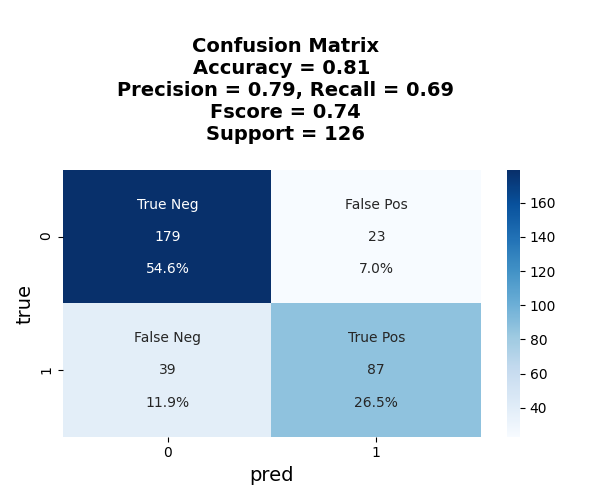

In [60]:
Image(filename='data_dir/artifacts/sagemaker_model_artifacts/model_cm_plot.png')

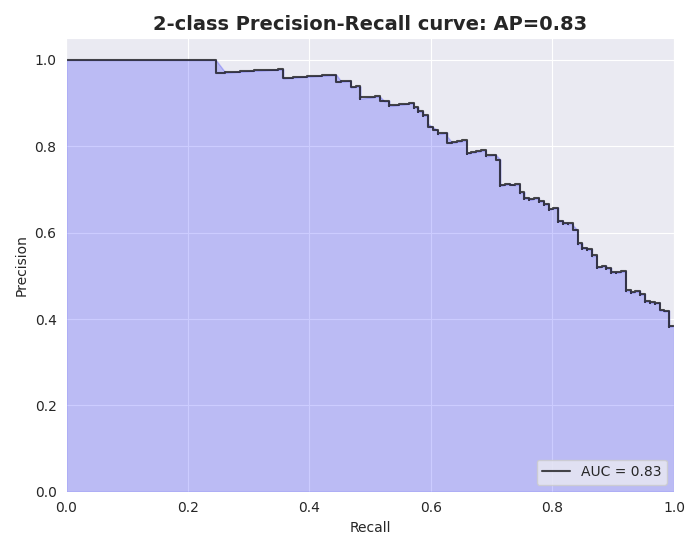

In [61]:
Image(filename='data_dir/artifacts/sagemaker_model_artifacts/model_pr_curve_plot.png')

In [152]:
import joblib
from sklearn import set_config
from sklearn.pipeline import Pipeline

In [211]:
path_pp_model = "data_dir/artifacts/sagemaker_pp_artifacts/model.joblib"
path_ml_model = "data_dir/artifacts/sagemaker_model_artifacts/model.joblib"

# these are the models extracted from PP_MODEL annd ML_MODEL containers
pp_model = joblib.load(path_pp_model)
ml_model = joblib.load(path_ml_model)

# current ml-pipeline structure
clf_model = Pipeline(steps=[('preprocessor', pp_model),
                      ('classifier', ml_model)])
set_config(display='diagram')
clf_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'sex',
                                                   'pclass'])],
                                   verbose=True)),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=2, n_jobs=-1))])

## SHAP

## Get pre-processed data
1. batch transform the raw_test --> pp_test data using trained sklearn_preprocessor model
2. fetch the transformed pre-processsed data from S3 bucket

In [154]:
# batch preprocess test data : s3_input_raw_test
pp_transformer.transform(s3_input_raw_test, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_test = pp_transformer.output_path

Waiting for transform job: sagemaker-scikit-learn-2020-09-19-17-22-50-626
............................2020-09-19 17:27:23,380 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-19 17:27:23,382 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-19 17:27:23,383 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read

2020-09-19T17:27:26.743:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD



In [203]:
colList_ML = ['age', 'fare', 'embarked_C', 'embarked_Q', 'embarked_S', 'gender_female', 'gender_male', 
              'pclass_1', 'pclass_2', 'pclass_3']
colList =[col_to_predict, "user_id"] + colList_ML

In [204]:
# fetch the pp data generated from bath job
s3uri     = s3_pp_test
file_name = '{}.out'.format(RAW_TEST_PATH.split("/")[-1])
s3_obj = get_csv_output_from_s3(s3uri, file_name)
df_pp  = pd.read_csv(io.StringIO(s3_obj), sep=",", header=None)

#df_pp = df_pp.drop(columns=[0,1])
df_pp.columns = colList

sagemaker-us-east-1-120286446822
sagemaker-scikit-learn-2020-09-19-17-22-50-626
test_titanic_dataset.csv.out


In [215]:
print(df_pp.shape)
df_pp.head(7)

(328, 12)


survived    user_id       age      fare  embarked_C  embarked_Q  \
0         0  user_1132 -0.118065 -0.509837         0.0         0.0   
1         1   user_245  0.277008  1.121465         0.0         0.0   
2         0  user_1298  0.514052 -0.476545         0.0         0.0   
3         0   user_426  0.039964 -0.403908         0.0         0.0   
4         0   user_861 -0.513137 -0.509231         0.0         0.0   
5         0  user_1306 -0.236587 -0.523759         1.0         0.0   
6         1   user_481 -0.592152  0.189207         1.0         0.0   

   embarked_S  gender_female  gender_male  pclass_1  pclass_2  pclass_3  
0         1.0            0.0          1.0       0.0       0.0       1.0  
1         1.0            1.0          0.0       1.0       0.0       0.0  
2         1.0            0.0          1.0       0.0       0.0       1.0  
3         1.0            0.0          1.0       0.0       1.0       0.0  
4         1.0            1.0          0.0       0.0       0.0       1.0  
5         0.0            0.0          1.0       0.0       0.0       1.0  
6         0.0            1.0          0.0       0.0       1.0       0.0

## SHAP - overall ML model performance

In [233]:
def shap_force_plot(instance_id=None, X=None, shap_explainer=None, ml_model=None, class_index=None, colList_ML=None):
    choosen_instance = X.loc[X["user_id"]==instance_id][colList_ML]

    pred_score = round(ml_model.predict_proba(choosen_instance)[0][class_index], 2)
    shap_values = shap_explainer.shap_values(choosen_instance)
    print("model_pred_score : {}".format(pred_score))

    f = shap.force_plot(shap_explainer.expected_value[class_index], shap_values[class_index], choosen_instance)
    return f

In [216]:
#!pip install shap
import shap

shap.initjs()

In [234]:
class_index = 1 # i.e predicting "if survived"

In [218]:
model = ml_model
X = df_pp.copy()
shap_explainer = shap.TreeExplainer(model)

In [219]:
instance_id = "user_861" # true : 0
shap_force_plot(instance_id=instance_id, X=X, shap_explainer=shap_explainer, ml_model=ml_model, 
                class_index=class_index, colList_ML=colList_ML)

model_pred_score : 0.67


In [220]:
instance_id = "user_245" # true : 1
shap_force_plot(instance_id=instance_id, X=X, shap_explainer=shap_explainer, ml_model=ml_model, 
                class_index=class_index, colList_ML=colList_ML)

model_pred_score : 1.0


In [223]:
instance_id = "user_1306" # true : 0
shap_force_plot(instance_id=instance_id, X=X, shap_explainer=shap_explainer, ml_model=ml_model, 
                class_index=class_index, colList_ML=colList_ML)

model_pred_score : 0.12


In [ ]:
#"dot" (default for single output), "bar" (default for multi-output), "violin",
#    or "compact_dot".
    
X = df_pp[colList_ML]

shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [243]:
shap.force_plot(shap_explainer.expected_value[class_index], shap_values[class_index][:1000,:], X.iloc[:1000,:])

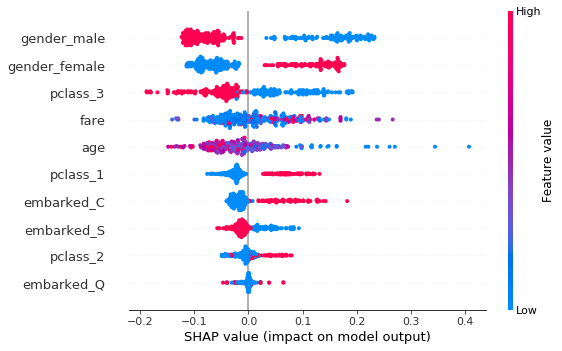

In [249]:
shap.summary_plot(shap_values[class_index], X, plot_type="dot")

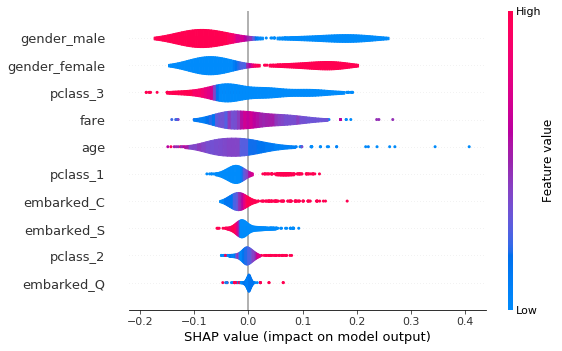

In [250]:
shap.summary_plot(shap_values[class_index], X, plot_type="violin")

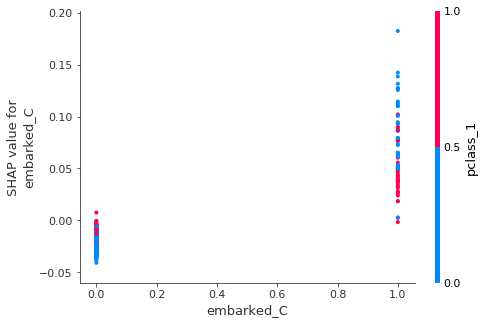

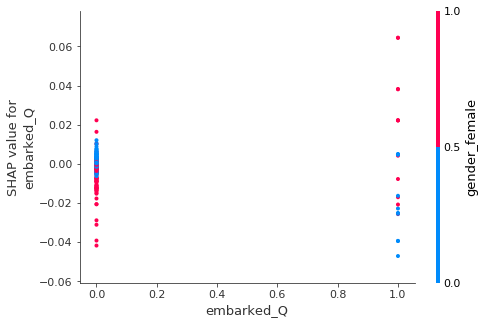

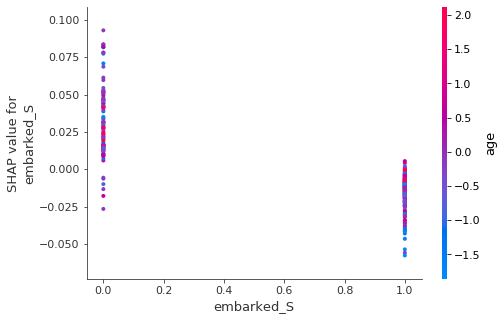

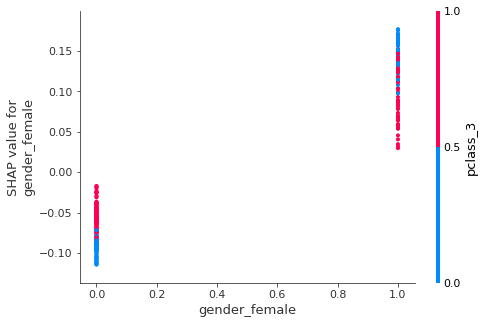

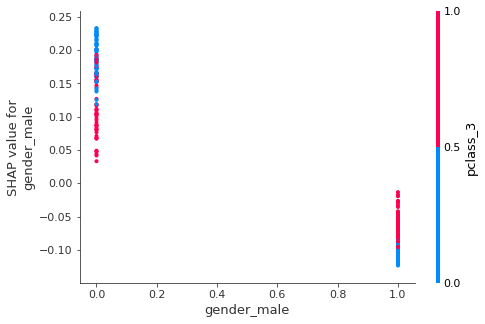

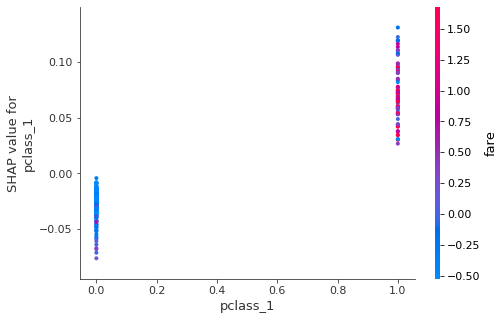

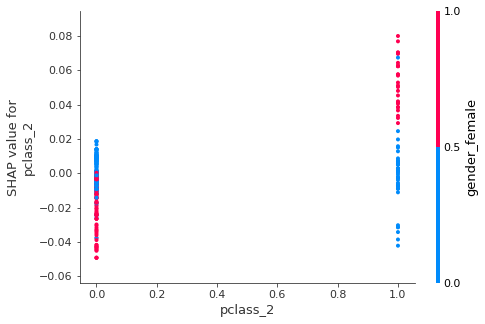

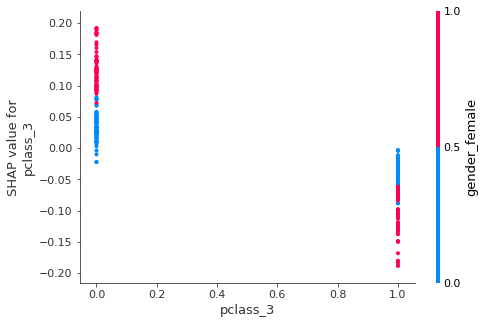

In [253]:
for name in colList_ML:
    shap.dependence_plot(name, shap_values[class_index], X, display_features=X)

In [ ]:
stop

## Delete Endpoint <a class="anchor" id="delete_endpoint"></a>
Once we are finished with the endpoint, we clean up the resources!

In [ ]:
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)

In [ ]:
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)